In [69]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../../modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import compose, pipeline, preprocessing, linear_model, model_selection, ensemble, feature_selection
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import product
import json
import warnings


# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

### Load all data

In [40]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(
    impute_missing=True, countries=countries
)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"],
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


/home/stei509/eu_migration_forecast/notebooks/final_paper/../../modules/eumf_data.py:238: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/home/stei509/eu_migration_forecast/notebooks/final_paper/../../modules/eumf_data.py:279: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
            AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Experiments

### Common definitions

In [91]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2019"
T_TEST_MAX = "2019"

cv_default = eumf_eval.BlockKFold(n_splits=8, margin=1.0)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
# n_countries = len(panel_comb_3m_macro["value"].columns)
# cv_time = model_selection.TimeSeriesSplit(test_size=4 * n_countries, n_splits=6)
with open("best_feature_combinations.json") as f:
    best_feature_combinations = json.load(f)

selected_keyword_ids = [
    "19",
    "118",
    "28",
    "24",
    "123",
    "119",
    "39",
    "115",
    "124",
    "117",
]

lags_default = [1, 2, 3, 4, 5, 6, 7, 8]
alternate_lags_default = {
    "value": [2, 3, 4, 5, 6, 7, 8],
    "gdp": [2, 3, 4, 5, 6, 7, 8],
    "unempl": [2, 3, 4, 5, 6, 7, 8],
}

variables_default = ["value", "gdp", "unempl"] + selected_keyword_ids


def adapt_features(
    features: list[str], step: int, l_max: int, l_min_alt: dict[str, int] = dict()
) -> list[str]:
    features_new = []
    for f in features:
        varname = f.split("_")[0]
        l = int(f.split("_")[-1])
        if varname in l_min_alt.keys():
            l_min = step + l_min_alt[varname] - 1
        else:
            l_min = step
        if l < l_min:
            f_next = varname + "_" + str(l_min)
            if f_next not in features_new and l_min <= l_max:
                features_new.append(f_next)
        else:
            if f not in features_new:
                features_new.append(f)
    return features_new


def shift_features(features: list[str], delta: int, l_max: int) -> list[str]:
    features_new = []
    for f in features:
        l = int(f.split("_")[-1])
        if l + delta <= l_max:
            f_next = f.split("_")[0] + "_" + str(l + delta)
            features_new.append(f_next)
    return features_new


In [97]:
### TRAINING
sub_model_names = [
    "bench_previous_2",
    "linear_without_ar",
    "linear_all",
    "linear_without_google",
    "ensemble_without_ar",
    "ensemble_all",
    "ensemble_without_google",
]

steps_ahead = (1, 2, 3, 4)

model_names = product(steps_ahead, sub_model_names)
model_names = ["_".join([str(s) for s in x]) for x in model_names]

features = [
    ["value_2"],
    best_feature_combinations["linear"]["without_ar"],
    best_feature_combinations["linear"]["all"],
    best_feature_combinations["linear"]["without_google"],
    best_feature_combinations["ensemble"]["without_ar"],
    best_feature_combinations["ensemble"]["all"],
    best_feature_combinations["ensemble"]["without_google"],
]

l_min_alt = {"value": 2, "gdp": 2, "unempl": 2}

base_estimators = [
    eumf_custom_models.LinearDummyModel(coef=[1.0]),
    linear_model.HuberRegressor(epsilon=1.1, alpha=0.08),
    linear_model.HuberRegressor(epsilon=1.7, alpha=0.00008),
    linear_model.HuberRegressor(epsilon=1.0, alpha=0.002),
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=9),
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=11),
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=12),
]

tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for step in tqdm(steps_ahead):
        for i, name in enumerate(tqdm(sub_model_names)):
            labeled = eumf_pipeline.prepare_data(
                panel_comb_3m_macro,
                columns=variables_default,
                lags=lags_default,
                alternate_lags=alternate_lags_default,
                t_min=T_MIN,
                t_max=T_MAX,
            )
            labeled.x = labeled.x[
                adapt_features(features[i], step, 8, l_min_alt=l_min_alt)
            ]
            transformed = eumf_pipeline.transform_data(labeled)
            train, test = eumf_pipeline.split_data(
                transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
            )
            train_stacked, test_stacked = eumf_pipeline.stack_data(
                train,
                test,
                extra_column=False if sub_model_names[i].startswith("bench_") else True,
            )

            train_stackeds.append(train_stacked)
            train_unstackeds.append(train)
            test_stackeds.append(test_stacked)

            if sub_model_names[i].startswith("bench_"):
                tuner = None
                estimator = base_estimators[i].fit(train_stacked.x, train_stacked.y)
            else:
                tuner = eumf_pipeline.train_reg_model(
                    train_stacked,
                    reg=base_estimators[i],
                    extra_pipeline_steps=[preprocessing.StandardScaler()],
                    params=params,
                    scoring=eumf_eval.scorer_mae,
                    cv=cv_default,
                    # cv=cv_default,
                    dummy_encoder="drop",
                )
                estimator = tuner.best_estimator_
            tuners.append(tuner)
            estimators.append(estimator)

            cv_score = eumf_eval.score_cv(
                estimator, train_stacked, cv=cv_default, return_train_score=True
            )
            cv_scores.append(cv_score)

            test_score = eumf_eval.score_test(
                estimator,
                test_stacked,
            )
            test_scores.append(test_score)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [98]:
pd.DataFrame(
    {k: t.best_params_ for k, t in zip(model_names, tuners) if t is not None}
).transpose()



""
1_linear_without_ar
1_linear_all
1_linear_without_google
1_ensemble_without_ar
1_ensemble_all
1_ensemble_without_google
2_linear_without_ar
2_linear_all
2_linear_without_google
2_ensemble_without_ar


In [99]:
df_cv_results = eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)
df_cv_results_complete = pd.concat(cv_scores)
df_cv_results


fit_time                       score_time                   test_mae               train_mae               test_rmse               train_rmse               test_explained_variance               train_explained_variance               test_r2_mod               train_r2_mod               test_delta_mae               train_delta_mae              
                            mean      std        sem        mean     std      sem       mean    std    sem      mean    std    sem      mean    std    sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem       mean      std    sem        mean       std    sem         mean       std    sem  
1_bench_previous_2          0.004   1.429e-03  5.053e-04    0.012    0.004  1.523e-03  -0.092   0.020  0.007   -0.093   0.005  0.002   -0.139   0.047  0.017   -0.146    0.012  0.004           0.107          0.201  0.071           0.388           0.077  0.027     0.231    0.305  0.108     0.466     0.097  0.034      0.034      0.056  0.020       0.037      0.014  0.005
1_linear_without_ar         0.051   2.168e-02  7.664e-03    0.017    0.005  1.734e-03  -0.088   0.029  0.010   -0.082   0.006  0.002   -0.131   0.050  0.018   -0.135    0.010  0.004           0.184          0.292  0.103           0.486           0.034  0.012     0.338    0.329  0.116     0.547     0.059  0.021      0.038      0.044  0.016       0.047      0.012  0.004
1_linear_all                0.399   1.891e-01  6.686e-02    0.018    0.005  1.681e-03  -0.071   0.019  0.007   -0.066   0.004  0.001   -0.107   0.040  0.014   -0.107    0.009  0.003           0.425          0.191  0.068           0.673           0.036  0.013     0.539    0.213  0.075     0.715     0.047  0.017      0.056      0.054  0.019       0.063      0.015  0.005
1_linear_without_google     0.074   4.077e-02  1.441e-02    0.011    0.006  2.196e-03  -0.077   0.024  0.009   -0.075   0.005  0.002   -0.115   0.045  0.016   -0.119    0.010  0.004           0.375          0.221  0.078           0.596           0.044  0.016     0.466    0.245  0.087     0.646     0.055  0.020      0.049      0.050  0.018       0.055      0.014  0.005
1_ensemble_without_ar       1.994   3.392e-01  1.199e-01    0.044    0.022  7.767e-03  -0.093   0.030  0.011   -0.058   0.004  0.001   -0.134   0.046  0.016   -0.095    0.008  0.003           0.126          0.377  0.133           0.736           0.051  0.018     0.230    0.469  0.166     0.770     0.060  0.021      0.034      0.050  0.018       0.071      0.015  0.005
1_ensemble_all              1.734   5.726e-01  2.024e-01    0.031    0.016  5.752e-03  -0.082   0.025  0.009   -0.057   0.003  0.001   -0.122   0.047  0.017   -0.097    0.009  0.003           0.328          0.120  0.043           0.724           0.058  0.021     0.442    0.205  0.072     0.759     0.067  0.024      0.045      0.051  0.018       0.072      0.016  0.006
1_ensemble_without_google   0.622   2.696e-01  9.532e-02    0.031    0.010  3.539e-03  -0.089   0.028  0.010   -0.068   0.004  0.001   -0.129   0.049  0.017   -0.109    0.009  0.003           0.259          0.111  0.039           0.652           0.063  0.022     0.381    0.208  0.074     0.697     0.075  0.026      0.038      0.046  0.016       0.061      0.014  0.005
2_bench_previous_2          0.007   1.995e-03  7.055e-04    0.024    0.006  2.133e-03  -0.113   0.034  0.012   -0.114   0.009  0.003   -0.168   0.059  0.021   -0.176    0.016  0.006          -0.221          0.323  0.114           0.109           0.118  0.042    -0.103    0.477  0.169     0.222     0.147  0.052      0.013      0.045  0.016       0.015      0.011  0.004
2_linear_without_ar         0.028   7.290e-03  2.577e-03    0.011    0.003  1.060e-03  -0.093   0.034  0.012   -0.086   0.007  0.002   -0.138   0.053  0.019   -0.139    0.010  0.004           0.123          0.295  0.104           0.447           0.037  0.013     0.271    0.345  0.122     0.516     0.063  0.022     

In [100]:
df_holdout_results = eumf_eval.agg_multiple_test_scores(test_scores, model_names)
df_holdout_results


,mae,rmse,explained_variance,r2_mod,delta_mae
1_bench_previous_2,-0.068,-0.094,-0.031,0.069,2.072e-03
1_linear_without_ar,-0.070,-0.097,-0.050,-0.001,6.671e-04
1_linear_all,-0.063,-0.082,0.257,0.298,7.403e-03
1_linear_without_google,-0.062,-0.082,0.293,0.297,8.670e-03
1_ensemble_without_ar,-0.072,-0.100,-0.140,-0.048,-1.879e-03
1_ensemble_all,-0.068,-0.095,-0.027,0.051,1.999e-03
1_ensemble_without_google,-0.068,-0.094,-0.006,0.070,2.227e-03
2_bench_previous_2,-0.074,-0.093,0.184,0.084,-3.788e-03
2_linear_without_ar,-0.075,-0.103,-0.171,-0.119,-4.588e-03
2_linear_all,-0.065,-0.087,0.145,0.198,5.454e-03


In [101]:
df_cv_results_complete


,fit_time,score_time,test_mae,train_mae,test_rmse,train_rmse,test_explained_variance,train_explained_variance,test_r2_mod,train_r2_mod,test_delta_mae,train_delta_mae
0,0.005,0.020,-0.110,-0.086,-0.167,-0.137,0.313,0.224,7.314e-01,0.230,0.151,0.007
1,0.003,0.016,-0.116,-0.088,-0.173,-0.132,0.347,0.447,5.661e-01,0.479,0.079,0.027
2,0.007,0.014,-0.096,-0.089,-0.190,-0.128,0.052,0.483,2.667e-01,0.536,0.031,0.035
3,0.004,0.008,-0.109,-0.092,-0.192,-0.144,0.348,0.424,3.763e-01,0.504,0.033,0.041
4,0.003,0.008,-0.078,-0.094,-0.100,-0.156,-0.011,0.390,-1.494e-04,0.508,-0.006,0.047
5,0.002,0.010,-0.096,-0.094,-0.126,-0.156,-0.094,0.364,-8.180e-02,0.509,-0.003,0.048
6,0.003,0.011,-0.080,-0.101,-0.100,-0.161,-0.142,0.377,-4.973e-02,0.488,-0.009,0.048
7,0.004,0.009,-0.055,-0.098,-0.069,-0.154,0.041,0.392,4.053e-02,0.472,-0.003,0.040
0,0.101,0.026,-0.143,-0.070,-0.209,-0.120,0.033,0.409,5.778e-01,0.413,0.118,0.023
1,0.059,0.016,-0.110,-0.078,-0.162,-0.128,0.349,0.489,6.170e-01,0.513,0.085,0.037


In [102]:
sub_model_names_long = sub_model_names * len(steps_ahead)
steps_ahead_long = [
    x for sub in [[s] * len(sub_model_names) for s in steps_ahead] for x in sub
]

df_cv_results["model"] = sub_model_names_long
df_cv_results["step"] = steps_ahead_long
df_holdout_results["model"] = sub_model_names_long
df_holdout_results["step"] = steps_ahead_long

df_cv_results_complete = pd.concat(
    [
        df.assign(**{"model": sub_model_names_long[i], "step": steps_ahead_long[i]})
        for i, df in enumerate(cv_scores)
    ]
).reset_index()


In [103]:
df_cv_results_complete

,index,fit_time,score_time,test_mae,train_mae,test_rmse,train_rmse,test_explained_variance,train_explained_variance,test_r2_mod,train_r2_mod,test_delta_mae,train_delta_mae,model,step
0,0,0.005,0.020,-0.110,-0.086,-0.167,-0.137,0.313,0.224,7.314e-01,0.230,0.151,0.007,bench_previous_2,1
1,1,0.003,0.016,-0.116,-0.088,-0.173,-0.132,0.347,0.447,5.661e-01,0.479,0.079,0.027,bench_previous_2,1
2,2,0.007,0.014,-0.096,-0.089,-0.190,-0.128,0.052,0.483,2.667e-01,0.536,0.031,0.035,bench_previous_2,1
3,3,0.004,0.008,-0.109,-0.092,-0.192,-0.144,0.348,0.424,3.763e-01,0.504,0.033,0.041,bench_previous_2,1
4,4,0.003,0.008,-0.078,-0.094,-0.100,-0.156,-0.011,0.390,-1.494e-04,0.508,-0.006,0.047,bench_previous_2,1
5,5,0.002,0.010,-0.096,-0.094,-0.126,-0.156,-0.094,0.364,-8.180e-02,0.509,-0.003,0.048,bench_previous_2,1
6,6,0.003,0.011,-0.080,-0.101,-0.100,-0.161,-0.142,0.377,-4.973e-02,0.488,-0.009,0.048,bench_previous_2,1
7,7,0.004,0.009,-0.055,-0.098,-0.069,-0.154,0.041,0.392,4.053e-02,0.472,-0.003,0.040,bench_previous_2,1
8,0,0.101,0.026,-0.143,-0.070,-0.209,-0.120,0.033,0.409,5.778e-01,0.413,0.118,0.023,linear_without_ar,1
9,1,0.059,0.016,-0.110,-0.078,-0.162,-0.128,0.349,0.489,6.170e-01,0.513,0.085,0.037,linear_without_ar,1


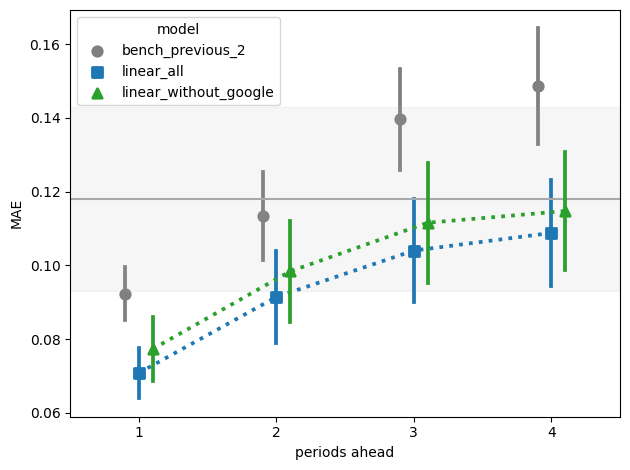

In [104]:
ax = sns.pointplot(
    data=df_cv_results_complete[
        df_cv_results_complete["model"].isin(
            ["bench_previous_2", "linear_all", "linear_without_google"]
        )
    ],
    y=-df_cv_results_complete["test_mae"],
    hue="model",
    # style="model",
    x="step",
    dodge=0.2,
    errorbar=("se", 1),
    # ci=68,
    linestyles=["", ":", ":"],
    palette=["tab:gray", "tab:blue", "tab:green"],
    markers=["o", "s", "^"],
)
# ax = sns.lineplot(
#     data=df_cv_results_complete,
#     y=-df_cv_results_complete["test_mae"],
#     hue="model",
#     style="model",
#     x="step",
#     # dodge=True,
#     ci=68,
#     markers=True,
# )
plt.axhline(0.118, c="darkgrey", ls="-")
plt.axhspan(0.118 - 0.025, 0.118 + 0.025, alpha=0.1, color="darkgrey")
# plt.setp(ax.collections[0], alpha=0.1)
# plt.setp(ax.collections[1], alpha=0.1)
# plt.setp(ax.collections[2], alpha=0.1)
# plt.setp(ax.collections[3], alpha=0.1)
plt.ylabel("MAE")
plt.xlabel("periods ahead")
plt.tight_layout()
plt.savefig("plots/forecasting_horizon.pdf")
plt.show()
